# Prereqs

In [1]:
import matplotlib.pyplot as plt
#from src.core.utils.helper import draw_template, load_anchor_points
import torch
import numpy as np
import random

import json_tricks as json
import matplotlib.pyplot as plt
#from src.core.utils.helper import draw_template, load_anchor_points
import torch
import numpy as np
import random

In [11]:
def show_tensor(mytensor):
    mytensor_cpu = mytensor.squeeze().cpu()
    mytensor_numpy = mytensor_cpu.detach().numpy()
    plt.imshow(mytensor_numpy.transpose((1, 2, 0)))
    plt.show()

    
def showpoints(anchors, markersize = 2):
    #colors = ['#fc0cd2', '#54693f', '#ed28fd', '#3bfb0a', '#678916', '#f48f70', '#f447f1', '#3271ed', '#190b45', '#1a243c', '#9271b7', '#c25ec8', '#3c605a', '#e67c03', '#5e6674', '#4a9aa2', '#92910c', '#7b857f']
    colors = ["#%06x" % random.randint(0, 0xFFFFFF) for j in range(18)]

    i = 0
    for section in anchors:
        if section.shape[3] != 0:
            #print(section)
            for part in section.squeeze(0):
                #print(a)
                #print(part)
                for joint in part:
                    x = float(joint[0,0])
                    y = float(joint[1,0])
                    plt.plot(x, y, marker="o", color="r", markersize=markersize)
                i += 1
                
def prep_heatmap(warped_heatmaps):
    warped_heatmaps_cpu = warped_heatmaps.squeeze().cpu()
    warped_heatmaps_cpu_numpy = warped_heatmaps_cpu.detach().numpy()
    #warped_heatmaps_cpu_numpy_sum = np.sum(warped_heatmaps_cpu_numpy, 0)
    return warped_heatmaps_cpu_numpy

In [3]:
from src.core.utils.helper import load_config
cfg = load_config("configs/baseline.yaml")

device = torch.device('cuda:0')

/scratch/network/nobliney/project/src/core/utils/helper.py:9: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(file)


In [4]:
import json_tricks as json

def draw_shape(pos, sigma_x, sigma_y, angle, size):
    """
    draw (batched) gaussian with sigma_x, sigma_y on 2d grid

    Args:
        pos: torch.tensor (float) with shape (2) specifying center of gaussian blob (x: row, y:column)
        sigma_x: torch.tensor (float scalar), scaling parameter along x-axis
        sigma_y: similar along y-axis
        angle: torch.tensor (float scalar) rotation angle in radians
        size: int specifying size of image
        device: torch.device, either cpu or gpu

    Returns:
        torch.tensor (1, 1, size, size) with gaussian blob
    """
    device = pos.device
    assert sigma_x.device == sigma_y.device == angle.device == device, "inputs should be on the same device!"

    # create 2d meshgrid
    x, y = torch.meshgrid(torch.arange(0, size), torch.arange(0, size))
    x, y = x.unsqueeze(0).unsqueeze(0).to(device), y.unsqueeze(0).unsqueeze(0).to(device)

    # see https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function
    a = torch.cos(angle) ** 2 / (2 * sigma_x ** 2) + torch.sin(angle) ** 2 / (2 * sigma_y ** 2)
    b = -torch.sin(2 * angle) / (4 * sigma_x ** 2) + torch.sin(2 * angle) / (4 * sigma_y ** 2)
    c = torch.sin(angle) ** 2 / (2 * sigma_x ** 2) + torch.cos(angle) ** 2 / (2 * sigma_y ** 2)

    # append dimsensions for broadcasting
    pos = pos.view(1, 1, 2, 1, 1)
    a, b, c = a.view(1, 1), b.view(1, 1), c.view(1, 1)

    # pixel-wise distance from center
    xdist = (x - pos[:, :, 0])
    ydist = (y - pos[:, :, 1])

    # gaussian function
    g = torch.exp((-a * xdist ** 2 - 2 * b * xdist * ydist - c * ydist ** 2))

    return g

def draw_template(template, size, batch_size, device):
    """
    draw template consisting of limbs defined by gaussian heatmap
    Args:
        template: json file defining all parts
        size: int, image size (assumed quadratic), this should match the center coordinates defined in the json!
        device: torch.device, either cpu or gpu
    """
    heatmaps = []
    for v in template.values():
        center = torch.tensor(v['center']).to(device)
        sx = torch.tensor(v['sx']).to(device)
        sy = torch.tensor(v['sy']).to(device)
        angle = torch.tensor(v['angle']).to(device)
        heatmaps.append(draw_shape(center, sx, sy, angle, size))

    heatmaps = torch.cat(heatmaps, dim=1).repeat(batch_size, 1, 1, 1)

    return heatmaps

def load_anchor_points_double_only(anchor_points, device, batch_size):
    """
    load anchor points from json file
    change this according to your definitions
    Args:
        anchor_points: json file containing anchor points per part in column, row format similar to open-cv
        device: torch.device, either cpu or gpu
    """
    
    # assumes three anchor points for core, two (parent+child) for all others except hands and feet and head
    # change this accordingly for different template definitions!
    double = []
    for k, v in anchor_points.items():
        double.append(v)

    return torch.tensor(double).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1)

def load_anchor_points(anchor_points, device, batch_size):
    """
    load anchor points from json file
    change this according to your definitions
    Args:
        anchor_points: json file containing anchor points per part in column, row format similar to open-cv
        device: torch.device, either cpu or gpu
    """
    
    # assumes three anchor points for core, two (parent+child) for all others except hands and feet and head
    # change this accordingly for different template definitions!
    double = []
    single = []
    #print("helper.py anchor_points items: ", anchor_points.items())
    for k, v in anchor_points.items():
        if k in ['left hand', 'right hand', 'left foot', 'right foot', 'head']:
            single.append(v)
        elif k == 'core':
            triple = [v]
        else:
            double.append(v)

    return torch.tensor(triple).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1), \
           torch.tensor(single).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1), \
           torch.tensor(double).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1)

def load_anchor_points_simple(anchor_points, device, batch_size):
    """
    load anchor points from json file
    change this according to your definitions
    Args:
        anchor_points: json file containing anchor points per part in column, row format similar to open-cv
        device: torch.device, either cpu or gpu
    """
    
    # assumes three anchor points for core, two (parent+child) for all others except hands and feet and head
    # change this accordingly for different template definitions!
    double = []
    single = []
    #print("helper.py anchor_points items: ", anchor_points.items())
    for k, v in anchor_points.items():
        if k in ['left hand', 'right hand', 'left foot', 'right foot', 'head', 'left arm', 'right arm']:
            single.append(v)
        elif k == 'core':
            triple = [v]
        else:
            double.append(v)

    return torch.tensor(triple).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1), \
           torch.tensor(single).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1), \
           torch.tensor(double).to(device).float().unsqueeze(-1).unsqueeze(0).repeat(batch_size, 1, 1, 1, 1)

    

# Create new template

In [5]:
with open(cfg['template_path'], 'r') as file:
    template_json = json.load(file)
    
with open(cfg['anchor_pts_path'], 'r') as file:
    anchor_points = json.load(file)


In [6]:
#new_anchor_points

"""
{'left arm': [[112, 80, 1], [88, 80, 1]],
 'right arm': [[144, 80, 1], [168, 80, 1]],
 'left forearm': [[88, 80, 1], [68, 80, 1]],
 'right forearm': [[168, 80, 1], [188, 80, 1]],
 'left hand': [[68, 80, 1]],
 'right hand': [[188, 80, 1]]}
"""

#new_template
"""
{'left arm': OrderedDict([('center', [80, 96]),
              ('sx', 6.4),
              ('sy', 10.24),
              ('angle', 0)]),
 'right arm': OrderedDict([('center', [80, 160]),
              ('sx', 6.4),
              ('sy', 10.24),
              ('angle', 0)]),
 'left forearm': OrderedDict([('center', [80, 72]),
              ('sx', 6.4),
              ('sy', 10.24),
              ('angle', 0)]),
 'right forearm': OrderedDict([('center', [80, 184]),
              ('sx', 6.4),
              ('sy', 10.24),
              ('angle', 0)]),
 'left hand': OrderedDict([('center', [80, 56]),
              ('sx', 5.12),
              ('sy', 6.4),
              ('angle', 0)]),
 'right hand': OrderedDict([('center', [80, 200]),
              ('sx', 5.12),
              ('sy', 6.4),
              ('angle', 0)])}
"""

"\n{'left arm': OrderedDict([('center', [80, 96]),\n              ('sx', 6.4),\n              ('sy', 10.24),\n              ('angle', 0)]),\n 'right arm': OrderedDict([('center', [80, 160]),\n              ('sx', 6.4),\n              ('sy', 10.24),\n              ('angle', 0)]),\n 'left forearm': OrderedDict([('center', [80, 72]),\n              ('sx', 6.4),\n              ('sy', 10.24),\n              ('angle', 0)]),\n 'right forearm': OrderedDict([('center', [80, 184]),\n              ('sx', 6.4),\n              ('sy', 10.24),\n              ('angle', 0)]),\n 'left hand': OrderedDict([('center', [80, 56]),\n              ('sx', 5.12),\n              ('sy', 6.4),\n              ('angle', 0)]),\n 'right hand': OrderedDict([('center', [80, 200]),\n              ('sx', 5.12),\n              ('sy', 6.4),\n              ('angle', 0)])}\n"

In [349]:
parts = ["left arm", "right arm", 
         "left forearm", "right forearm", "left hand", "right hand"]
new_template = {}
for k,v in template_json.items():
    if k in parts:
        new_template[k] = v

new_anchor_points = {}
for k,v in anchor_points.items():
    if k in parts:
        new_anchor_points[k] = v

new_template['left arm']['angle'] = np.radians(-60) # clockwise
new_template['right arm']['angle'] = np.radians(60) # clockwise
new_template['left arm']['center'] = [93, 100] # (y, x)
new_template['right arm']['center'] = [93, 156] # (y, x)
new_anchor_points["left arm"] = [[112, 80, 1], [93, 102, 1]] # [88, 80, 1]
new_anchor_points["right arm"] = [[144, 80, 1], [160, 102, 1]]

new_template['left forearm']['angle'] = np.radians(-80)
new_template['right forearm']['angle'] = np.radians(80)
new_template['left forearm']['center'] = [118, 90]
new_template['right forearm']['center'] = [118, 165]

new_anchor_points["left forearm"] = [[93, 102, 1], [86, 127, 1]] # [88, 80, 1]
new_anchor_points["right forearm"] = [[160, 102, 1], [167, 127, 1]]

new_template['left hand']['center'] = [138, 87]
new_template['left hand']['angle'] = np.radians(-80)

new_template['right hand']['center'] = [138, 170]
new_template['right hand']['angle'] = np.radians(80)

new_anchor_points['left hand'] = [[93, 102, 1]]
new_anchor_points['right hand'] = [[167, 127, 1]]


#new_template
template = draw_template(template_json, size=cfg['img_size'], batch_size=1,
                                      device=device)

core, single, double = load_anchor_points(new_anchor_points, device, 1)

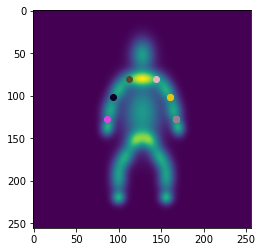

In [350]:
template_nums = template.squeeze(0).cpu().detach().numpy()
templates_sum = np.sum(template_nums, 0)

plt.imshow(templates_sum)
showpoints([core, double, single])
plt.show()

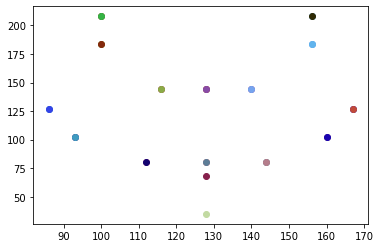

In [14]:
showpoints([core, double, single])


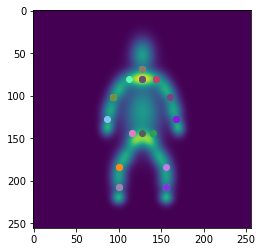

In [363]:
with open(cfg['template_path'], 'r') as file:
    template_json = json.load(file)
    
with open(cfg['anchor_pts_path'], 'r') as file:
    anchor_points = json.load(file)


template_json['left arm']['angle'] = np.radians(-60) # clockwise
template_json['right arm']['angle'] = np.radians(60) # clockwise
template_json['left arm']['center'] = [93, 100] # (y, x)
template_json['right arm']['center'] = [93, 156] # (y, x)
anchor_points["left arm"] = [[112, 80, 1], [93, 102, 1]] # [88, 80, 1]
anchor_points["right arm"] = [[144, 80, 1], [160, 102, 1]]

template_json['left forearm']['angle'] = np.radians(-80)
template_json['right forearm']['angle'] = np.radians(80)
template_json['left forearm']['center'] = [118, 90]
template_json['right forearm']['center'] = [118, 165]

anchor_points["left forearm"] = [[93, 102, 1], [86, 127, 1]] # [88, 80, 1]
anchor_points["right forearm"] = [[160, 102, 1], [167, 127, 1]]

template_json['left hand']['center'] = [138, 87]
template_json['left hand']['angle'] = np.radians(-80)

template_json['right hand']['center'] = [138, 170]
template_json['right hand']['angle'] = np.radians(80)

anchor_points['left hand'] = [[86, 127, 1]]
anchor_points['right hand'] = [[167, 127, 1]]

template = draw_template(template_json, size=cfg['img_size'], batch_size=1,
                                      device=device)

core, single, double = load_anchor_points(anchor_points, device, 1)

template_nums = template.squeeze(0).cpu().detach().numpy()
templates_sum = np.sum(template_nums, 0)

plt.imshow(templates_sum)
showpoints([core, double, single])
plt.show()

In [364]:
with open("template_new.json", 'w+') as file:
    json.dump(template_json, file)
    
with open("anchor_points_new.json", 'w+') as file:
    json.dump(anchor_points, file)

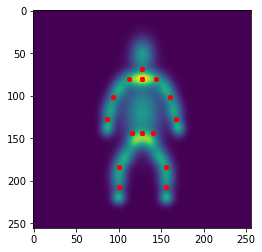

In [15]:
with open("template_naturalg1.json", 'r') as file:
    template_json = json.load(file)
    
with open("anchor_points_naturalg1.json", 'r') as file:
    anchor_points = json.load(file)
    
#anchor_points['core'] = [[128, 144, 1], [128, 80, 1], [128, 35, 1]]
template = draw_template(template_json, size=cfg['img_size'], batch_size=1,
                         device=device)

core, single, double = load_anchor_points(anchor_points, device, 1)

template_nums = template.squeeze(0).cpu().detach().numpy()
templates_sum = np.sum(template_nums, 0)

plt.imshow(templates_sum)
showpoints([core, double, single], markersize=4)
plt.show()

In [5]:
import json

#dict_1 = {"core": {"center": [120, 128], "sx": 15.36, "sy": 25.6, "angle": 1.5708}, "left hip": {"center": [152, 120], "sx": 6.4, "sy": 7.68, "angle": -0.9}, "right hip": {"center": [152, 136], "sx": 6.4, "sy": 7.68, "angle": 0.9}, "left thigh": {"center": [172, 108], "sx": 6.4, "sy": 10.24, "angle": -1.1}, "right thigh": {"center": [172, 148], "sx": 6.4, "sy": 10.24, "angle": 1.1}, "left shin": {"center": [196, 100], "sx": 6.4, "sy": 12.8, "angle": 1.5708}, "right shin": {"center": [196, 156], "sx": 6.4, "sy": 12.8, "angle": -1.5708}, "left shoulder": {"center": [80, 120], "sx": 6.4, "sy": 10.24, "angle": 0}, "right shoulder": {"center": [80, 136], "sx": 6.4, "sy": 10.24, "angle": 0}, "left arm": {"center": [80, 96], "sx": 6.4, "sy": 10.24, "angle": 0}, "right arm": {"center": [80, 160], "sx": 6.4, "sy": 10.24, "angle": 0}, "left forearm": {"center": [80, 72], "sx": 6.4, "sy": 10.24, "angle": 0}, "right forearm": {"center": [80, 184], "sx": 6.4, "sy": 10.24, "angle": 0}, "left foot": {"center": [220, 100], "sx": 5.12, "sy": 5.12, "angle": 0}, "right foot": {"center": [220, 156], "sx": 5.12, "sy": 5.12, "angle": 0}, "left hand": {"center": [80, 56], "sx": 5.12, "sy": 6.4, "angle": 0}, "right hand": {"center": [80, 200], "sx": 5.12, "sy": 6.4, "angle": 0}, "head": {"center": [52, 128], "sx": 12.8, "sy": 8.96, "angle": 0}}

dict2 = {"head": [0,1], "left shoulder": [1,2], "right shoulder": [1,5], "left arm": [2,3], "right arm": [5,6], "left forearm": [3,4], "right forearm": [6,7], "core": [1,8], "left hip": [8,9], "right hip": [8,12], "left thigh": [9,10], "right thigh": [12,13], "left shin": [10,11], "right shin": [13,14]}

for k in dict2:
    if k == "core":
        dict2[k] = {"anchors": dict2[k], "thickness": 20}
    else:
        dict2[k] = {"anchors": dict2[k], "thickness": 10}

with open("template_joints.json", "w") as f1:
    json.dump(dict2, f1)

In [15]:
num_anchor_pts = 0
for k,v in anchor_points.items():
    num_anchor_pts += len(v)
num_anchor_pts

32

In [ ]:
"""
(top of head)[128, 35, 1], (neck)[128, 80, 1], (left shoulder)[112, 80, 1], (left arm)[93, 102, 1], (left wrist)[86, 127, 1]
(right shoulder)[144, 80, 1], (right arm)[160, 102, 1], (right wrist)[167, 127, 1],
(butt)[128, 144, 1], (left hip)[116, 144, 1], (left knee)[100, 184, 1], (left ankle)[100, 208, 1],
(right hip)[140, 144, 1], (right knee)[156, 184, 1], (right ankle)[156, 208, 1]

"""

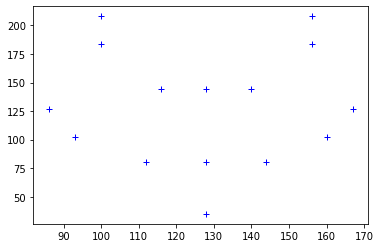

In [13]:
joints = [[128, 35, 1], [128, 80, 1], [112, 80, 1], [93, 102, 1], [86, 127, 1], 
          [144, 80, 1], [160, 102, 1], [167, 127, 1], [128, 144, 1], [116, 144, 1], [100, 184, 1], [100, 208, 1],
          [140, 144, 1], [156, 184, 1], [156, 208, 1]]

for pt in joints:
    x = pt[0]
    y = pt[1]
    plt.plot(x, y, "b+")
plt.show()


In [9]:
from src.core.utils.losses import compute_anchor_loss

compute_anchor_loss(core, double, single, 256)

tensor(0., device='cuda:0')

In [366]:
with open("anchor_points_new.json", 'r') as file:
    anchor_points_new = json.load(file)
with open("anchor_points.json", 'r') as file:
    anchor_points = json.load(file)

In [367]:
for k in anchor_points:
    if anchor_points[k] != anchor_points_new[k]:
        print(k)
        print(anchor_points[k])
        print(anchor_points_new[k])
        input()

left arm
[[112, 80, 1], [88, 80, 1]]
[[112, 80, 1], [93, 102, 1]]


right arm
[[144, 80, 1], [168, 80, 1]]
[[144, 80, 1], [160, 102, 1]]


left forearm
[[88, 80, 1], [68, 80, 1]]
[[93, 102, 1], [86, 127, 1]]


right forearm
[[168, 80, 1], [188, 80, 1]]
[[160, 102, 1], [167, 127, 1]]


left hand
[[68, 80, 1]]
[[86, 127, 1]]


right hand
[[188, 80, 1]]
[[167, 127, 1]]


# Transform template correctly

In [72]:
with open("template_new.json", 'r') as file:
    template_json = json.load(file)
    
with open("anchor_points_new.json", 'r') as file:
    anchor_points = json.load(file)
    
template = draw_template(template_json, size=cfg['img_size'], batch_size=48,
                         device=device)

template = template.unsqueeze(2).repeat(1, 1, 3, 1, 1)
template = template.sum(1, keepdims=True)



In [73]:
template.shape

torch.Size([48, 1, 3, 256, 256])

In [57]:
template = template.unsqueeze(2).repeat(1, 1, 3, 1, 1)
template.sum(1, keepdims=True).shape

torch.Size([1, 3, 256, 256])

In [33]:
template = template.sum(1).unsqueeze(0)

In [34]:
template.shape

torch.Size([1, 1, 256, 256])

In [ ]:
        batched_template = self.template.view(-1, img_size, img_size).unsqueeze(1)


# Template Doubles Only New

In [23]:
import json_tricks as json
import matplotlib.pyplot as plt
#from src.core.utils.helper import draw_template, load_anchor_points
import torch
import numpy as np
import random

from src.core.utils.helper import load_config
cfg = load_config("configs/direct_loss_calc_anchors.yaml")

device = torch.device('cuda:0')

with open("template_new.json", 'r') as file:
    template_json = json.load(file)
    
with open("anchor_points_new.json", 'r') as file:
    anchor_points = json.load(file)


In [24]:
# delete hand and foot
del template_json['left hand']
del template_json['right hand']
del template_json['left foot']
del template_json['right foot']
template_json['head']['center'] = [64, 128]
template_json['core']['sx'] = 11

In [25]:
del anchor_points['left hand']
del anchor_points['right hand']
del anchor_points['left foot']
del anchor_points['right foot']
anchor_points['core'] = [[128, 144, 1], [128, 80, 1]]
anchor_points['head'] = [[128, 80, 1], [128, 47, 1]]
anchor_points['left shoulder'] = [[128, 80, 1], [110, 80, 1]]
anchor_points['right shoulder'] = [[128, 80, 1], [146, 80, 1]]
anchor_points['left arm'] = [[110, 80, 1], [93, 102, 1]]
anchor_points['right arm'] = [[146, 80, 1], [160, 102, 1]]

In [26]:
anchor_points['left hip'] = [[128, 144, 1], [113, 157, 1]]
anchor_points['right hip'] = [[128, 144, 1], [143, 157, 1]]
anchor_points['left thigh'] = [[113, 157, 1], [100, 184, 1]]
anchor_points['right thigh'] = [[143, 157, 1], [156, 184, 1]]

In [16]:
def prep_heatmap(warped_heatmaps):
    warped_heatmaps_cpu = warped_heatmaps.squeeze().cpu()
    warped_heatmaps_cpu_numpy = warped_heatmaps_cpu.detach().numpy()
    #warped_heatmaps_cpu_numpy_sum = np.sum(warped_heatmaps_cpu_numpy, 0)
    return warped_heatmaps_cpu_numpy

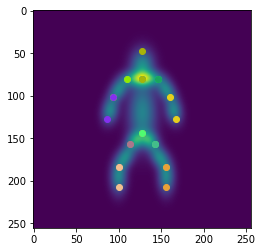

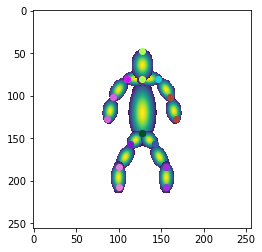

In [28]:
#anchor_points['core'] = [[128, 144, 1], [128, 80, 1], [128, 35, 1]]
template = draw_template(template_json, size=cfg['img_size'], batch_size=1,
                         device=device)

double = load_anchor_points_double_only(anchor_points, device, 1)

template_nums = template.squeeze(0).cpu().detach().numpy()
templates_sum = np.sum(template_nums, 0)


plt.imshow(templates_sum)
showpoints([double])
plt.show()

for i in prep_heatmap(template):
    i = np.ma.masked_where(i <= 0.3, i)
    plt.imshow(i)
showpoints([double])
plt.show()

In [29]:
with open("template_doubles_only_new.json", "w") as file:
    json.dump(template_json, file)
with open("anchor_points_doubles_only_new.json", "w") as file:
    json.dump(anchor_points, file)

# Template Doubles Only Original

In [5]:


from src.core.utils.helper import load_config
cfg = load_config("configs/direct_loss_calc_anchors.yaml")

device = torch.device('cuda:0')

with open("template.json", 'r') as file:
    template_json = json.load(file)
    
with open("anchor_points.json", 'r') as file:
    anchor_points = json.load(file)


In [6]:
# delete hand and foot
del template_json['left hand']
del template_json['right hand']
del template_json['left foot']
del template_json['right foot']
template_json['head']['center'] = [64, 128]
template_json['core']['sx'] = 11

In [139]:
del anchor_points['left hand']
del anchor_points['right hand']
del anchor_points['left foot']
del anchor_points['right foot']
anchor_points['core'] = [[128, 144, 1], [128, 80, 1]]
anchor_points['head'] = [[128, 80, 1], [128, 47, 1]]

In [140]:
anchor_points['left hip'] = [[128, 144, 1], [113, 157, 1]]
anchor_points['right hip'] = [[128, 144, 1], [143, 157, 1]]
anchor_points['left thigh'] = [[113, 157, 1], [100, 184, 1]]
anchor_points['right thigh'] = [[143, 157, 1], [156, 184, 1]]

In [141]:
def prep_heatmap(warped_heatmaps):
    warped_heatmaps_cpu = warped_heatmaps.squeeze().cpu()
    warped_heatmaps_cpu_numpy = warped_heatmaps_cpu.detach().numpy()
    #warped_heatmaps_cpu_numpy_sum = np.sum(warped_heatmaps_cpu_numpy, 0)
    return warped_heatmaps_cpu_numpy

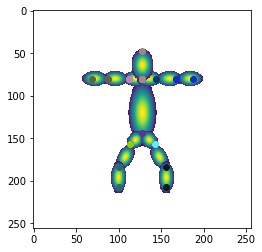

In [143]:
#anchor_points['core'] = [[128, 144, 1], [128, 80, 1], [128, 35, 1]]
template = draw_template(template_json, size=cfg['img_size'], batch_size=1,
                         device=device)

double = load_anchor_points_double_only(anchor_points, device, 1)

#template_nums = template.squeeze(0).cpu().detach().numpy()
#templates_sum = np.sum(template_nums, 0)

for i in prep_heatmap(template):
    i = np.ma.masked_where(i <= 0.3, i)
    plt.imshow(i)
showpoints([double])
plt.show()

In [144]:
with open("template_doubles_only_orig.json", "w") as file:
    json.dump(template_json, file)
with open("anchor_points_doubles_only_orig.json", "w") as file:
    json.dump(anchor_points, file)

# Simple Template

In [459]:
from collections import OrderedDict

device = torch.device('cuda:0')
with open("template.json", "r") as file:
    template_json = json.load(file)
with open("anchor_points.json", "r") as file:
    anchor_points_json = json.load(file)
    
#del template_json['left shoulder']
#del template_json['right shoulder']
#del template_json['left arm']
#del template_json['right arm']
del template_json['left forearm']
del template_json['right forearm']
del template_json['left hand']
del template_json['right hand']

# experimental
template_json['left arm']['center'] = [80, 82] # y, x
#template_json['left arm']['sx']
template_json['left arm']['sy'] = 19.48
#template_json['left arm']['angle']

template_json['right arm']['center'] = [80, 174] # y, x
#template_json['right arm']['sx']
template_json['right arm']['sy'] = 19.48
#template_json['right arm']['angle']

In [460]:
del anchor_points_json['left forearm']
del anchor_points_json['right forearm']
del anchor_points_json['left hand']
del anchor_points_json['right hand']

anchor_points_json['left arm'] = [[112, 80, 1], [53, 80, 1]] # x,y
anchor_points_json['right arm'] = [[144, 80, 1], [203, 80, 1]]


In [461]:
template = draw_template(template_json, size=cfg['img_size'], batch_size=1,
                         device=device)

anchor_points = load_anchor_points(anchor_points_json, device, 2)

#template_nums = template.squeeze(0).cpu().detach().numpy()
#templates_sum = np.sum(template_nums, 0)
"""for i in prep_heatmap(template):
    #i = np.ma.masked_where(i <= 0.3, i)
    #print(i.shape)
    plt.imshow(i)
"""
templates_sum = np.sum(prep_heatmap(template), 0)
plt.imshow(templates_sum)
showpoints(anchor_points)
plt.show()

# can use anchor points to figure out where the endpoints of each part is

TypeError: draw_shape() missing 1 required positional argument: 'batch_size'

In [462]:
with open("template_simple.json", "w") as f:
    json.dump(template_json, f)

with open("anchor_points_simple.json", "w") as f:
    json.dump(anchor_points_json, f)

In [23]:
simpletemplate_json = OrderedDict()
simpletemplate_json['left leg'] = OrderedDict()
simpletemplate_json['left leg']['center'] = [172, 108]
simpletemplate_json['left leg']['sx'] = 6.4
simpletemplate_json['left leg']['sy'] = 20.24
simpletemplate_json['left leg']['angle'] = -1.1

simpletemplate_json['right leg'] = OrderedDict()
simpletemplate_json['right leg']['center'] = [172, 142]
simpletemplate_json['right leg']['sx'] = 6.4
simpletemplate_json['right leg']['sy'] = 20.24
simpletemplate_json['right leg']['angle'] = 1.1

In [24]:
template.shape

torch.Size([1, 8, 256, 256])

# Calculate detailed from rough template

In [716]:
with open("anchor_points_simple.json") as f:
    anchor_points_json = json.load(f)

with open("template_simple.json") as f:
    template_json =json.load(f)

In [717]:
anchor_points_json['left arm'] = [[112, 80, 1], [53, 150, 1]]
anchor_points_json['right arm'] = [[144, 80, 1], [230, 150, 1]]

In [718]:
batch_size = 1
template = draw_template(template_json, size=cfg['img_size'], batch_size=batch_size,
                         device=device)

anchor_points = load_anchor_points(anchor_points_json, device, batch_size)

#templates_sum = np.sum(prep_heatmap(template), 0)
#plt.imshow(templates_sum)
#showpoints(anchor_points)
#plt.show()

# can use anchor points to figure out where the endpoints of each part is

In [719]:
midpoints_left = (torch.sum(anchor_points[2][:, 8], dim = 1) // 2) # shape: 2,3,1---batch_size, 3, 1
midpoints_right = (torch.sum(anchor_points[2][:, 9], dim = 1) // 2) # shape: 2,3,1---batch_size, 3, 1
anchor_points_detail = (anchor_points[0], 
                        torch.cat([anchor_points[1], torch.zeros(batch_size, 2, 1, 3, 1).to(device)], dim=1), 
                        torch.cat([anchor_points[2], torch.zeros(batch_size, 2, 2, 3, 1).to(device)], dim=1))
anchor_points_detail[2][:, 8, 1] = midpoints_left # left arm new anchor
anchor_points_detail[2][:, 9, 1] = midpoints_right # right arm new anchor
anchor_points_detail[2][:, 10] = torch.cat([midpoints_left.unsqueeze(1), anchor_points[2][:, 8, 1].unsqueeze(1)], dim=1) # left forearm shape: batch_size, 2, 3, 1
anchor_points_detail[2][:, 11] = torch.cat([midpoints_right.unsqueeze(1), anchor_points[2][:, 9, 1].unsqueeze(1)], dim=1) # right forearm shape: batch_size, 2, 3, 1
anchor_points_detail[1][:,3] = anchor_points[2][:, 8, 1].unsqueeze(1) # left hand anchor
anchor_points_detail[1][:,4] = anchor_points[2][:, 9, 1].unsqueeze(1) # right hand anchor



In [720]:
template_detail = torch.cat([template, torch.zeros(batch_size, 4, 256, 256).to(device)], dim=1)

template_detail[:,15] = template_detail[:,13]
template_detail[:,13] = template_detail[:,11]
template_detail[:,14] = template_detail[:,12]

In [721]:
ratio = 19.48/59 # 59 pixels = 19.48

In [722]:
for i in range(anchor_points_detail[2].shape[0]): # for each batch
    batch = anchor_points_detail[2][i]
    
    double_parts = [8, 9, 10, 11]

    for p in double_parts:
        # left arm
        diff = torch.diff(batch[p], dim=0)
        if diff[0,0] == 0:
            angle = torch.pi
        else:
            angle = torch.atan(diff[0,1] / diff[0,0])

        shape = draw_shape(torch.flip((torch.sum(batch[p], dim = 0) // 2)[0:2], dims = [0]), 
                   torch.tensor(6.4).to(device), 
                   ratio * torch.sqrt(torch.sum(torch.diff(batch[p], dim = 0) ** 2)),
                  angle,
                  256)
    
        template_detail[i,p+1] = shape.squeeze()

for i in range(anchor_points_detail[1].shape[0]): # for each batch
    batch = anchor_points_detail[1][i]
    
    p = 3
    shape = draw_shape(torch.flip(batch[p][0,0:2] - torch.tensor([[5],[0]]).to(device), dims = [0]), 
               torch.tensor(6.4).to(device), 
               torch.tensor(6.4).to(device),
              torch.tensor(0).to(device),
              256)
    template_detail[i,16] = shape.squeeze()
    
    p = 4
    shape = draw_shape(torch.flip(batch[p][0,0:2] + torch.tensor([[5],[0]]).to(device), dims = [0]), 
               torch.tensor(6.4).to(device), 
               torch.tensor(6.4).to(device), 
               torch.tensor(0).to(device),
              256)
    template_detail[i,17] = shape.squeeze()

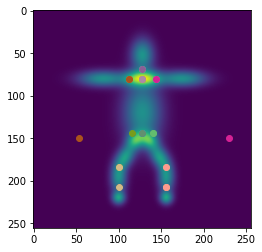

In [725]:
templates_sum = np.sum(prep_heatmap(template), 0)
plt.imshow(templates_sum)
showpoints(anchor_points)
plt.show()

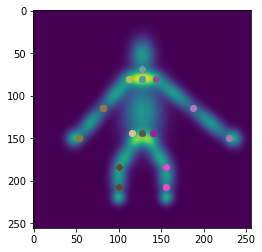

In [726]:
templates_sum = np.sum(prep_heatmap(template_detail), 0)
plt.imshow(templates_sum)
showpoints(anchor_points_detail)
plt.show()

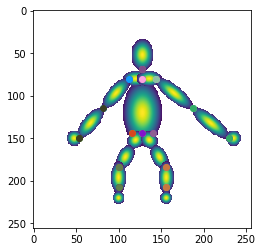

In [727]:
for i in prep_heatmap(template_detail):
    i = np.ma.masked_where(i <= 0.3, i)
    plt.imshow(i)
showpoints(anchor_points_detail)
plt.show()

# Elongated Feet Natural G1 Pose

In [63]:
with open("anchor_points_naturalg1.json", "r") as f:
    anchor_points_json = json.load(f)
    
with open("template_naturalg1.json", "r") as f:
    template_json = json.load(f)

In [64]:
template_json['left foot']['sx'] = 8
template_json['left foot']['angle'] = np.pi/8
template_json['left foot']['center'] = [220, 97]
template_json['right foot']['sx'] = 8
template_json['right foot']['angle'] = -np.pi/8
template_json['right foot']['center'] = [220, 159]

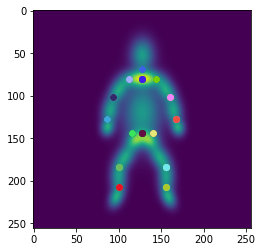

In [65]:
#new_template
template = draw_template(template_json, size=256, batch_size=1,
                                      device=device)

core, single, double = load_anchor_points(anchor_points_json, device, 1)

template_nums = template.squeeze(0).cpu().detach().numpy()
templates_sum = np.sum(template_nums, 0)

plt.imshow(templates_sum)
showpoints([core, double, single])
plt.show()

In [66]:
with open("anchor_points_naturalg1_elongatedfeet.json", "w") as f:
    json.dump(anchor_points_json, f)

with open("template_naturalg1_elongatedfeet.json", "w") as f:
    json.dump(template_json, f)

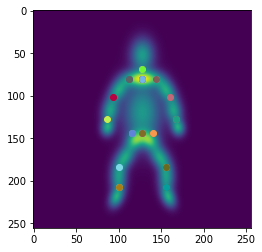

In [67]:
with open("anchor_points_naturalg1_elongatedfeet.json", "r") as f:
    anchor_points_json = json.load(f)
    
with open("template_naturalg1_elongatedfeet.json", "r") as f:
    template_json = json.load(f)
    
#new_template
template = draw_template(template_json, size=256, batch_size=1,
                                      device=device)

core, single, double = load_anchor_points(anchor_points_json, device, 1)

template_nums = template.squeeze(0).cpu().detach().numpy()
templates_sum = np.sum(template_nums, 0)

plt.imshow(templates_sum)
showpoints([core, double, single])
plt.show()